# Tuning Curves

**Import everything**

In [1]:
%matplotlib inline
import typing

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
import sympy as sp
sp.init_printing()
AxOrImg = typing.Union[mpl.axes.Axes, mpl.image.AxesImage]

In [2]:
k, x0, y0, phi, theta, sigma_x, sigma_y, sigma, x, y = sp.symbols(r'k x_0 y_0 \phi \theta \sigma_x \sigma_y \sigma x y')
defaults = {
    k: 6,
    sigma: 0.2,
    phi: sp.pi / 2,
    theta: 0,
    sigma: 1,
    x0: 0, y0: 0
}
sigma_x = sigma_y = sigma

#### Formulas

In [3]:
grating_f = sp.cos(k * (x - x0) * sp.cos(theta) + k * (y - y0) * sp.sin(theta) + phi)
receptive_field = 1 / (2 * sp.pi * sigma * sigma) * sp.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) * sp.cos(k * x * sp.cos(theta) + k * y * sp.sin(theta) + phi)
receptive_field = receptive_field.subs(theta, 0).subs(phi, 0)
grating_f

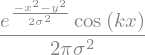

In [4]:
receptive_field

In [5]:
int1 = sp.Integral(grating_f * receptive_field, (x, -1, 1), (y, -1, 1)).subs(defaults)
# int1.evalf(2).doit()

In [6]:
# p = sp.cos(phi) * sp.cos(k*x0*sp.cos(theta) + k*y0*sp.sin(theta)) * sp.exp(k**2 * (sigma_x **2 * (1 + sp.cos(theta))**2 + sigma_y**2 * sp.sin(theta) **2) / 2)
# p = sp.cosh(k**2 * sigma**2 * sp.cos(theta)) * sp.exp(k ** 2 * (1 + sp.cos(theta) ** 2) / 2) * sp.cos(phi - k * (x0 * sp.cos(theta) + y0 * sp.sin(theta)))

p = sp.cosh(k ** 2 * sigma ** 2 * sp.cos(theta) * 4) * sp.exp(-4 * k ** 2 * sigma ** 2) * sp.cos(
    phi - k * (x0 * sp.cos(theta) + y0 * sp.sin(theta)))
p

#### Plot stuff

In [7]:
def get_orientation_phase_grid(step_phase: float, step_orientation: float) -> np.ndarray:
    """
    Returns a grid of x and y values for plotting.
    :param step_phase: step for the phase (phi) - in degrees
    :param step_orientation: step for the orientation (theta) - in degrees
    :return: numpy array of shape (n_orientation, n_phase). Each element is a tuple (theta, phi)
    """
    # phase <-> phi
    # orientation <-> theta
    step_phase *= np.pi / 180
    step_orientation *= np.pi / 180
    phi = np.arange(0, 2 * np.pi, step_phase)
    theta = np.arange(0, np.pi, step_orientation)
    return np.array(np.meshgrid(theta, phi)).T.reshape(-1, len(phi), 2)


def get_spatial_grid(step_x: float, step_y: float, size: float = 1) -> np.ndarray:
    """
    Returns a grid of x and y values for plotting.
    :param step_x: step for the x-coordinate
    :param step_y: step for the y-coordinate
    :param size: size of the grid
    :return: numpy array of shape (2 * size / step_x, 2 * size / step_y). Each element is a tuple (x, y)
    """
    x = np.arange(-size, size, step_x)
    y = np.arange(-size, size, step_y)
    return np.array(np.meshgrid(x, y)).T.reshape(-1, len(x), 2)

In [8]:
def eval_func(func: sp.Expr, sub_1: sp.Expr, sub_2: sp.Expr, grid: np.ndarray) -> np.ndarray:
    # return np.array([[float(func.subs(sub_1, x_).subs(sub_2, y_)) for x_, y_ in line] for line in grid])
    func = sp.lambdify([sub_1, sub_2], func, 'numpy')
    return func(grid[:, :, 0], grid[:, :, 1])

def plot_spatial(func: sp.Expr, ax: AxOrImg, step_x: float = 0.05, step_y: float = 0.05, size: float = 1, title: str = None, show: bool = False,
                 patch: typing.Optional[typing.Tuple[float, float, float]] = None
                 ):
    """
    Plots a spatial map of the function.

    :param func: function to plot
    :param ax: axes to plot on or the image on axes
    :param step_x: step for the x-coordinate
    :param step_y: step for the y-coordinate
    :param size: size of the grid
    :param title: title of the plot
    :param show: whether to show the plot
    :param patch: optional circle to plot - a tuple (x, y, radius)
    """
    grid = get_spatial_grid(step_x, step_y, size)
    image: np.ndarray = eval_func(func, x, y, grid)
    if isinstance(ax, mpl.image.AxesImage):
        ax.set_data(image)
        return ax
    img = ax.imshow(image, extent=[-size, size, -size, size], vmin=-size, vmax=size, cmap='gray')
    ax.invert_yaxis()
    if patch is not None:
        ax.add_patch(plt.Circle(patch[:2], radius=patch[2], color='b', fill=False))
    ax.set_title(title)
    if show:
        plt.show()
    return img

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_tuning_curve(func: typing.Union[sp.Expr, typing.Callable], ax: AxOrImg, step_phase: float = 20, step_orientation: float = 15, title: str = None, show: bool = False):
    """
    Plots a tuning curve of the function.

    :param func: function to plot - sympy or a function of (theta, phi)
    :param ax: axes to plot on or image to update
    :param step_phase: step for the phase (phi) - in degrees
    :param step_orientation: step for the orientation (theta) - in degrees
    :param title: title of the plot
    :param show: whether to show the plot
    """
    grid = get_orientation_phase_grid(step_phase, step_orientation)
    if isinstance(func, sp.Expr):
        image: np.ndarray = eval_func(func, theta, phi, grid)
    else:
        image = np.array([[func(theta_val, phi_val) for theta_val, phi_val in line] for line in grid])
    image = normalize(image)
    if isinstance(ax, mpl.image.AxesImage):
        ax.set_data(image)
        return ax
    img = ax.imshow(image, extent=[0, 360, 0, 180], cmap='viridis')
    ax.set_title(title)
    if show:
        plt.show()
    return img

In [9]:
def plot_gratings(ax: typing.Union[plt.Axes, mpl.image.AxesImage], k_val: float, phi_val: float, theta_val: float, x0_val: float = 0, y0_val: float = 0):
    phi_val *= np.pi / 180
    theta_val *= np.pi / 180
    return plot_spatial(
        # grating_f.evalf(subs={k: k_val, x0: x0_val, y0: y0_val, theta: theta_val, phi: phi_val}),
        grating_f.subs(k, k_val).subs(x0, x0_val).subs(y0, y0_val).subs(theta, theta_val).subs(phi, phi_val),
        ax, step_x=0.05, step_y=0.05, size=1, title='Grating', show=False)

def plot_receptive_field(ax: plt.Axes, k_val: float, phi_val: float, theta_val: float, sigma_val: float = 1):
    phi_val *= np.pi / 180
    theta_val *= np.pi / 180
    return plot_spatial(
        receptive_field.subs(k, k_val).subs(theta, theta_val).subs(phi, phi_val).subs(sigma, sigma_val),
        ax, step_x=0.05, step_y=0.05, size=1, title='Receptive field', show=False)

In [10]:
def get_value(k_val: float = defaults[k], phi_val: float = 90, theta_val: float = 0, x0_val: float = 0, y0_val: float = 0, sigma_val: float = defaults[sigma]):
    phi_val *= np.pi / 180
    theta_val *= np.pi / 180
    grid_size = 0.05
    grid = get_spatial_grid(grid_size, grid_size, 1)
    subs = {
        k: k_val,
        x0: x0_val,
        y0: y0_val,
        theta: theta_val,
        phi: phi_val,
        sigma: sigma_val
    }
    grating_img = eval_func(grating_f.subs(subs), x, y, grid)
    rf_img = eval_func(receptive_field.subs(subs), x, y, grid)
    return np.sum(grating_img * rf_img) * grid_size ** 2

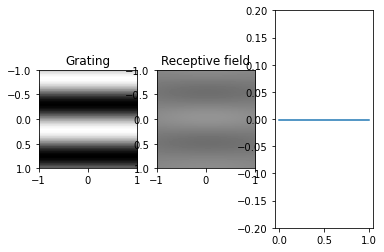

interactive(children=(FloatSlider(value=6.0, description='k', max=10.0, step=0.2), FloatSlider(value=90.0, des…

In [11]:
fig, ax = plt.subplots(1, 3)
img_gr = plot_gratings(ax[0], defaults[k], 90, 0, 0, 0)
img_rf = plot_receptive_field(ax[1], defaults[k], 90, 90, defaults[sigma])
val = get_value()
line = ax[2].plot([val, val])[0]
ax[2].set(ylim=[-0.2, 0.2])

@widgets.interact(
    k_val=widgets.FloatSlider(min=0, max=10, step=0.2, value=defaults[k], description='k'),
    phi_val=widgets.FloatSlider(min=0, max=360, step=10, value=90, description='phi'),
    theta_val=widgets.FloatSlider(min=0, max=180, step=10, value=0, description='theta'),
    x0_val=widgets.FloatSlider(min=-1, max=1, step=0.05, value=0, description='x0'),
    y0_val=widgets.FloatSlider(min=-1, max=1, step=0.05, value=0, description='y0'),
    sigma_val=widgets.FloatSlider(min=0, max=1, step=0.05, value=defaults[sigma], description='sigma'),
)
def plot_stuff(k_val, phi_val, theta_val, x0_val, y0_val, sigma_val):
    plot_gratings(img_gr, k_val, phi_val, theta_val, x0_val, y0_val)
    plot_receptive_field(img_rf, k_val, phi_val, theta_val, sigma_val)
    val = get_value(k_val, phi_val, theta_val, x0_val, y0_val, sigma_val)
    line.set_ydata([val, val])
    fig.canvas.draw_idle()

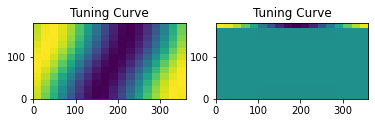

interactive(children=(FloatSlider(value=0.8, description='k', max=10.0, step=0.2), FloatSlider(value=0.8, desc…

In [14]:
fig, ax = plt.subplots(1, 2)
DEF_K, DEF_SIGMA, DEF_X = 0.8, 0.05, 0.8
get_tuning_curve_func = lambda k_val, x0_val, y0_val, sigma_val: lambda theta_val, phi_val: get_value(k_val, phi_val * 180 / np.pi, theta_val * 180 / np.pi, x0_val, y0_val, sigma_val)
left_img = plot_tuning_curve(get_tuning_curve_func(DEF_K, DEF_X, 0, DEF_SIGMA), ax[0], title='Tuning Curve')
right_img = plot_tuning_curve(p.subs({k: defaults[k], x0: defaults[x0], y0: defaults[y0], sigma: defaults[sigma]}), ax[1], title='Tuning Curve')

@widgets.interact(
    k_val=widgets.FloatSlider(min=0, max=10, step=0.2, value=DEF_K, description='k'),
    x0_val=widgets.FloatSlider(min=-1, max=1, step=0.05, value=DEF_X, description='x0'),
    y0_val=widgets.FloatSlider(min=-1, max=1, step=0.05, value=0, description='y0'),
    sigma_val=widgets.FloatSlider(min=0, max=1, step=0.05, value=DEF_SIGMA, description='sigma'),
)
def plot_tuning_curves(k_val, x0_val, y0_val, sigma_val):
    plot_tuning_curve(get_tuning_curve_func(k_val, x0_val, y0_val, sigma_val), left_img, title='Tuning Curve - Numeric')
    plot_tuning_curve(p.subs({k: k_val, x0: x0_val, y0: y0_val, sigma: sigma_val}), right_img, title='Tuning Curve - Analytic')
    fig.canvas.draw_idle()

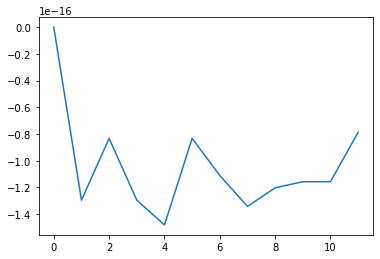

In [13]:
# %matplotlib inline
func_1 = get_tuning_curve_func(DEF_K, DEF_X, 0, DEF_SIGMA)
func_2 = p.subs({k: DEF_K, x0: DEF_X, y0: 0, sigma: DEF_SIGMA})
grid = get_orientation_phase_grid(15, 15)
img_1 = np.array([[func_1(theta, phi) for theta, phi in line] for line in grid])
img_2 = eval_func(func_2, theta, phi, grid)
plt.plot(np.mean(img_2, axis=1))
plt.show()

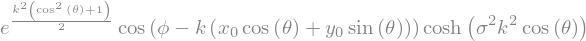

In [14]:
p